Nesse notebook resolvi esse problema com um número menor de dados utilizando VGG e Resnet: https://github.com/g-roger/analises-imagens-medicas/blob/main/analise_imagens_medicas.ipynb

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras import Model, layers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import pandas as pd
from sklearn.utils import shuffle
from keras.utils.vis_utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_validation = 0.30
train_data_folder = '/content/drive/MyDrive/Estudos/FIAP/Deep Learning/Coronahack-Chest-XRay-Dataset/train'
test_data_folder = '/content/drive/MyDrive/Estudos/FIAP/Deep Learning/Coronahack-Chest-XRay-Dataset/test'

In [4]:
df_summary = pd.read_csv('/content/drive/MyDrive/Estudos/FIAP/Deep Learning/Coronahack-Chest-XRay-Dataset/Chest_xray_Corona_dataset_Summary.csv')
df_metadata = pd.read_csv('/content/drive/MyDrive/Estudos/FIAP/Deep Learning/Coronahack-Chest-XRay-Dataset/Chest_xray_Corona_Metadata.csv')

In [5]:
df_summary

,Unnamed: 0,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,0,Normal,NaN,NaN,1576
1,1,Pnemonia,Stress-Smoking,ARDS,2
2,2,Pnemonia,Virus,NaN,1493
3,3,Pnemonia,Virus,COVID-19,58
4,4,Pnemonia,Virus,SARS,4
5,5,Pnemonia,bacteria,NaN,2772
6,6,Pnemonia,bacteria,Streptococcus,5


In [6]:
df_metadata

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [7]:
train_data = df_metadata[df_metadata['Dataset_type'] == 'TRAIN']
test_data = df_metadata[df_metadata['Dataset_type'] == 'TEST']

Será positivo se estiver com covid ou com pneumonia, caso contrário negativo.

In [8]:
train_data_class = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]


train_data_class['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in train_data_class['Label']]
train_data_class = shuffle(train_data_class, random_state=1)

validation_data = train_data_class.iloc[1100:, :]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [9]:
train_data_class

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,target
547,547,IM-0740-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
754,754,NORMAL2-IM-0587-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
1283,1283,NORMAL2-IM-1316-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
1128,1128,NORMAL2-IM-1122-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
1063,1063,NORMAL2-IM-1038-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
...,...,...,...,...,...,...,...
715,715,NORMAL2-IM-0569-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
905,905,NORMAL2-IM-0868-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
1096,1096,NORMAL2-IM-1088-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
235,235,IM-0429-0001-0002.jpeg,Normal,TRAIN,NaN,NaN,negative


In [10]:
# Normalização e ajustes nas imagens

train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=[0.9, 1.25],
    brightness_range=[0.5, 1.5]
)

#Treino e validação

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data_class,
    directory=train_data_folder,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=16,
    shuffle=True,
    class_mode='binary'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=validation_data,
    directory=train_data_folder,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=16,
    shuffle=True,
    class_mode='binary'
)

Found 1400 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [11]:
train_generator.class_indices, validation_generator.class_indices


({'negative': 0, 'positive': 1}, {'negative': 0, 'positive': 1})

In [12]:
model = Sequential()
model.add(Conv2D(filters=128, kernel_size=(3,3),  activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=3)) 
model.add(Conv2D(filters=64, kernel_size=(3,3),  activation='relu'))   
model.add(MaxPooling2D(pool_size=3)) 
model.add(Conv2D(filters=32, kernel_size=(3,3),  activation='relu'))   
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

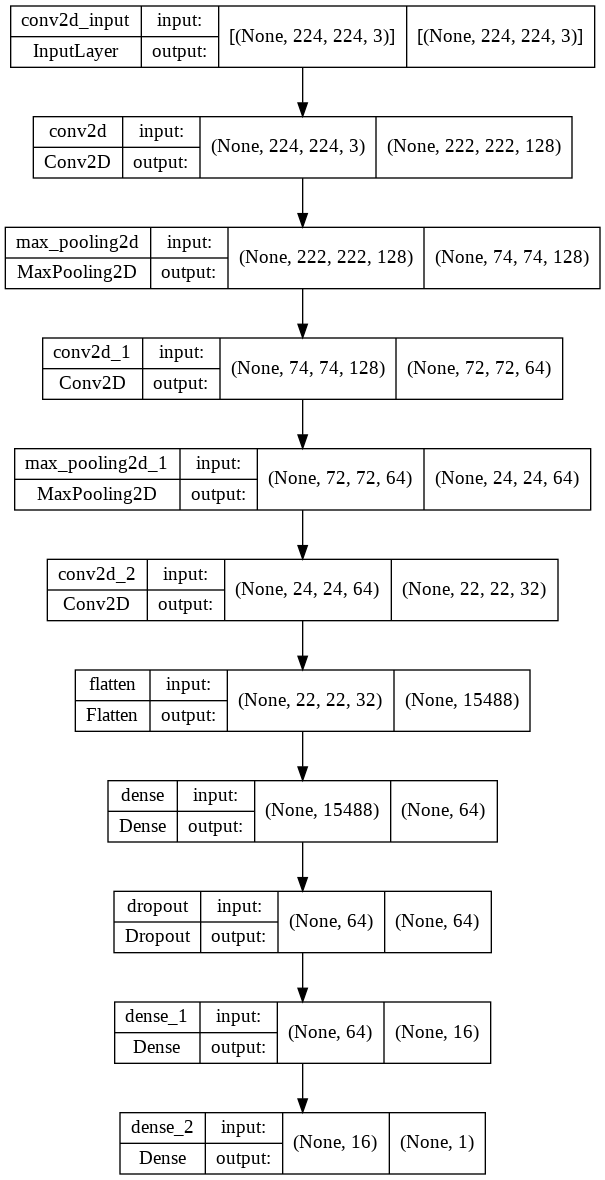

In [13]:
plot_model(model, to_file='chest-xray-cnn.png', show_shapes=True, show_layer_names=True)


In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])                  


In [15]:
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/xray.hdf5', verbose=1,  save_best_only=True, monitor='accuracy')
hist = model.fit_generator(train_generator,validation_data=validation_generator, epochs=10, callbacks=[checkpointer])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
88/88 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.9471
Epoch 1: accuracy improved from -inf to 0.94714, saving model to /content/drive/My Drive/xray.hdf5
88/88 [==============================] - 75s 763ms/step - loss: 0.0000e+00 - accuracy: 0.9471 - val_loss: 0.0000e+00 - val_accuracy: 0.9500
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.9586
Epoch 2: accuracy improved from 0.94714 to 0.95857, saving model to /content/drive/My Drive/xray.hdf5
88/88 [==============================] - 67s 762ms/step - loss: 0.0000e+00 - accuracy: 0.9586 - val_loss: 0.0000e+00 - val_accuracy: 0.9500
Epoch 3/10
88/88 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.9586
Epoch 3: accuracy did not improve from 0.95857
88/88 [==============================] - 61s 696ms/step - loss: 0.0000e+00 - accuracy: 0.9586 - val_loss: 0.0000e+00 - val_accuracy: 0.9500
Epoch 4/10
88/88 [====================

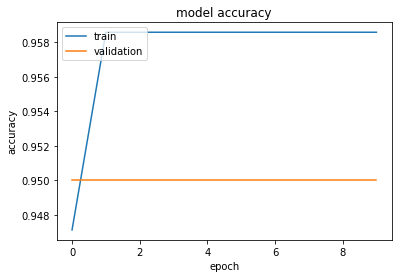

In [16]:
plt.figure(1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()